<a href="https://colab.research.google.com/github/ctclumak/Tensorflow-2-and-Keras-Deep-Learning/blob/master/GANs(Generative_Adversarial_Networks).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(X_train,y_train), (X_test,y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


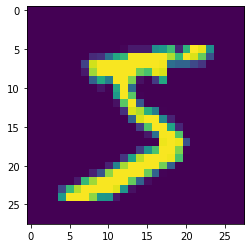

In [4]:
plt.imshow(X_train[0])

In [5]:
y_train==0

array([False,  True, False, ..., False, False, False])

In [0]:
only_zeros = X_train[y_train==0]

In [7]:
only_zeros.shape

(5923, 28, 28)

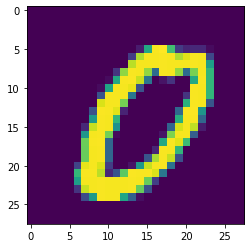

In [8]:
plt.imshow(only_zeros[233])

In [0]:
import tensorflow as tf
tf.enable_eager_execution()
from tensorflow.keras.layers import Dense,Reshape,Flatten
from tensorflow.keras.models import Sequential

In [0]:
discriminator = Sequential()
discriminator.add(Flatten(input_shape=[28,28]))
discriminator.add(Dense(150,activation="relu"))
discriminator.add(Dense(100,activation="relu"))

In [0]:
#Final output layer
discriminator.add(Dense(1,activation='sigmoid'))

discriminator.compile(loss="binary_crossentropy",optimizer="adam")

**Create the generator**

In [0]:
#784->150->30->150-784  the coding size should be much less than the original feature size
coding_size = 100
#100->150->784
generator=Sequential()
generator.add(Dense(100, activation="relu", input_shape=[coding_size]))
generator.add(Dense(150,activation='relu'))
generator.add(Dense(784,activation='relu'))
generator.add(Reshape([28,28]))   # we dont compile the generator, coz it is trained  using the GAN

In [0]:
GAN = Sequential([generator,discriminator])
discriminator.trainable=False # it should not be train, so set it to false, so we can compile it using GAN

GAN.compile(loss="binary_crossentropy",optimizer="adam")

In [0]:
#set up the batch
batch_size = 32

my_data=only_zeros

In [0]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [0]:
dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1) # prefetch set to 1 to train 1 epoch


In [0]:
epochs = 1

In [18]:
GAN.layers[0].layers


In [19]:
GAN.layers[1].layers


In [20]:
GAN.layers[0].summary() #check out the summary of the generator model


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               118384    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 143,634
Trainable params: 143,634
Non-trainable params: 0
_________________________________________________________________


In [21]:
GAN.layers[1].summary() #check out the summary of the discreminator model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 150)               117750    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 265,902
Trainable params: 132,951
Non-trainable params: 132,951
_________________________________________________________________


In [0]:
generator, discriminator = GAN.layers

In [23]:


# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i=i+1
        if i%100 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_data)//batch_size}")
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, coding_size])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
        
        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        # This gets rid of a Keras warning
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, coding_size])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")   

Currently on Epoch 1
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
	Currently on batch number 100 of 185
TRAINING COMPLETE


In [24]:
noise = tf.random.normal(shape=[10,coding_size])
noise.shape

TensorShape([Dimension(10), Dimension(100)])

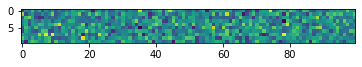

In [25]:
plt.imshow(noise)

In [26]:
images = generator(noise)
images.shape

TensorShape([Dimension(10), Dimension(28), Dimension(28)])

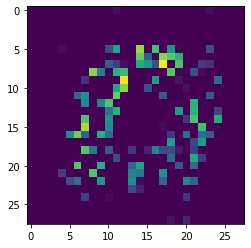

In [27]:
plt.imshow(images[0])

**Reshape and Rescale Images for DCGAN**

In [0]:
X_train = X_train/255

In [0]:

# After reshaping the data, we multiple it with 2, to have everything between 0 to 2 and then go to negative 1 
# and the highest values set to go to 1 and then your minimum becomes negative 1 and your maximum becomes 1
X_train = X_train.reshape(-1,28,28,1)*2. - 1.  

In [30]:
X_train.min(), X_train.max()

(-1.0, 1.0)

**Filter out the Data for faster training on smaller dataset**

In [0]:
only_zeros = X_train[y_train==0]

In [32]:
only_zeros.shape

(5923, 28, 28, 1)

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape,Dropout, LeakyReLU,Flatten,BatchNormalization,Conv2D,Conv2DTranspose

In [0]:
from tensorflow.keras.models import Sequential

In [0]:
np.random.seed(42)

codings_size=100

In [0]:
generator = Sequential()
generator.add(Dense(7*7*128, input_shape=[codings_size]))
generator.add(Reshape([7,7,128]))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(64,kernel_size=5, strides=2, padding="same", 
                              activation = "relu"))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(1,kernel_size=5, strides=2, padding="same", 
                              activation = "relu"))


In [0]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                         activation = LeakyReLU(0.3),
                         input_shape=[28,28,1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2DTranspose(128,kernel_size=5, strides=2, padding="same",
                                  activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1,activation="sigmoid"))



In [0]:
GAN = Sequential([generator,discriminator])

In [0]:
discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False

In [40]:
GAN.compile(loss="binary_crossentropy", optimizer = "adam")
GAN.layers

In [41]:
GAN.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 28, 28, 1)         840705    
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 306945    
Total params: 1,147,650
Trainable params: 840,321
Non-trainable params: 307,329
_________________________________________________________________


In [0]:
#set up the batch
batch_size = 32

my_data=only_zeros

In [0]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1) # prefetch set to 1 to train 1 epoch


In [0]:
epochs = 20

**Training Looop**

In [45]:
generator, discriminator = GAN.layers



# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i=i+1
        if i%100 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_data)//batch_size}")
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, coding_size])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
        
        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        # This gets rid of a Keras warning
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, coding_size])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")   

Currently on Epoch 1
	Currently on batch number 100 of 185
Currently on Epoch 2
	Currently on batch number 100 of 185
Currently on Epoch 3
	Currently on batch number 100 of 185
Currently on Epoch 4
	Currently on batch number 100 of 185
Currently on Epoch 5
	Currently on batch number 100 of 185
Currently on Epoch 6
	Currently on batch number 100 of 185
Currently on Epoch 7
	Currently on batch number 100 of 185
Currently on Epoch 8
	Currently on batch number 100 of 185
Currently on Epoch 9
	Currently on batch number 100 of 185
Currently on Epoch 10
	Currently on batch number 100 of 185
Currently on Epoch 11
	Currently on batch number 100 of 185
Currently on Epoch 12
	Currently on batch number 100 of 185
Currently on Epoch 13
	Currently on batch number 100 of 185
Currently on Epoch 14
	Currently on batch number 100 of 185
Currently on Epoch 15
	Currently on batch number 100 of 185
Currently on Epoch 16
	Currently on batch number 100 of 185
Currently on Epoch 17
	Currently on batch number 

In [46]:
noise = tf.random.normal(shape=[10,coding_size])
noise.shape

TensorShape([Dimension(10), Dimension(100)])

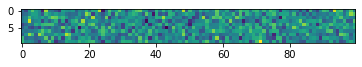

In [47]:
plt.imshow(noise)

In [0]:
images = generator(noise)
single_image = images[1]

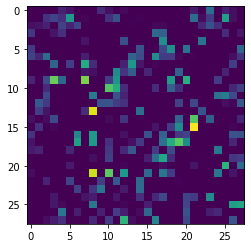

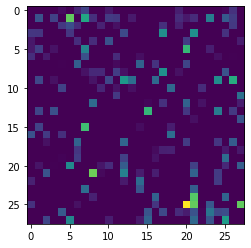

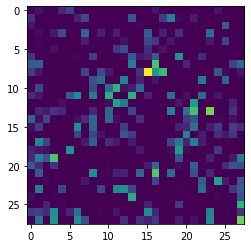

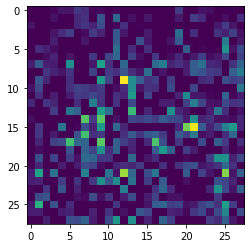

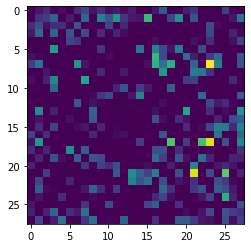

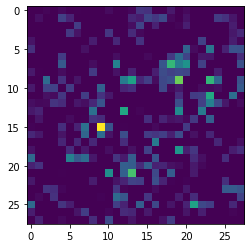

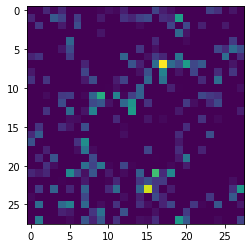

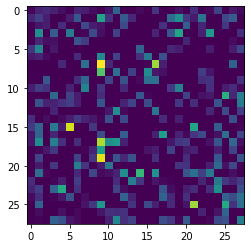

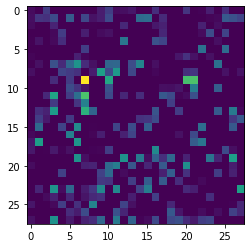

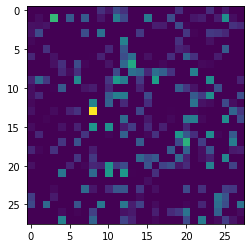

In [56]:
for image in images:
  plt.imshow(image.numpy().reshape(28,28))
  plt.show()